In [1]:

import pandas as pd
import numpy as np
import sys
import os

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../" * 2))
sys.path.insert(0, BASE_DIR)

from setting import plt
from mod.data_process.numpy import normalize
from giefstat.statistical_tools.time_delayed_association import detect_time_delayed_assoc

Use environmental variables in default.yml


载入测试数据

In [2]:
data = pd.read_csv(f"{BASE_DIR}/dataset/time_delayed/siso.csv")

In [3]:
data

,No.,x_linear_static,y_linear_static,x_linear_dynamic,y_linear_dynamic,x_nonlinear_static,y_nonlinear_static,x_nonlinear_dynamic,y_nonlinear_dynamic
0,0,-9.656718,14.636749,7.788669,-0.210509,-9.656718,213.735967,7.788669,-0.540770
1,1,7.788669,-5.501806,-20.713848,0.554406,7.788669,30.317920,-20.713848,0.818975
2,2,-20.713848,-4.743758,15.703306,0.140380,-20.713848,22.605985,15.703306,0.064931
3,3,15.703306,-9.634309,-6.850862,-0.130665,15.703306,93.274604,-6.850862,1.351047
4,4,-6.850862,7.807344,2.871352,-0.044626,-6.850862,60.682035,2.871352,0.049104
...,...,...,...,...,...,...,...,...,...
1995,1995,5.826376,1.698224,12.481430,0.081806,5.826376,2.881622,12.481430,0.024938
1996,1996,12.481430,5.062278,4.405650,-0.079306,12.481430,25.498970,4.405650,0.104930
1997,1997,4.405650,-8.293347,2.149163,-0.164749,4.405650,68.807473,2.149163,-30.157493
1998,1998,2.149163,5.814957,-4.033006,0.110367,2.149163,33.935239,-4.033006,0.037491


In [4]:
labels = ["linear_static", "linear_dynamic", "nonlinear_static", "nonlinear_dynamic"]

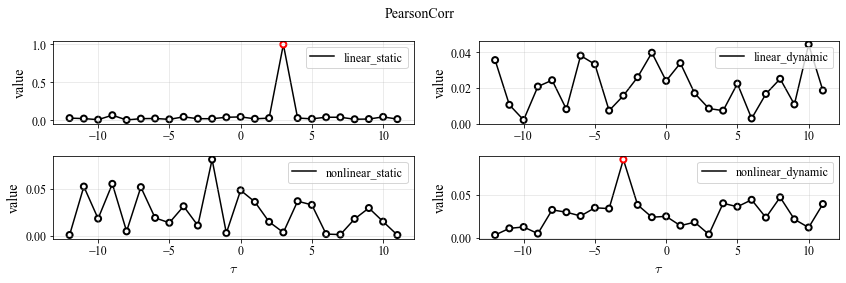

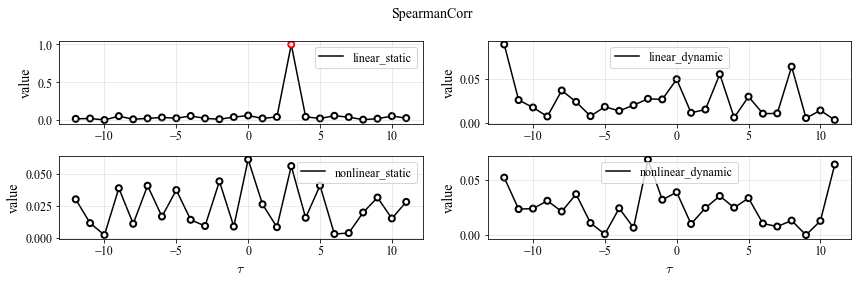

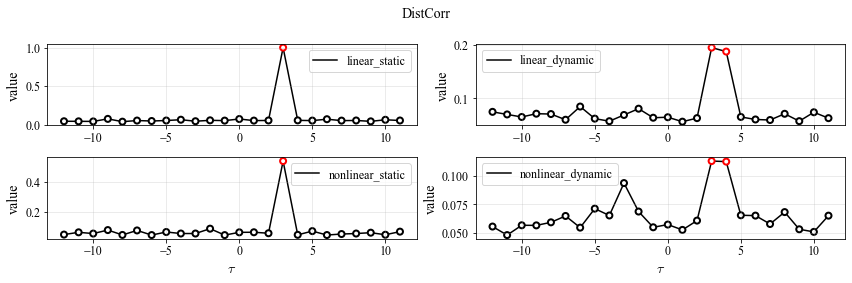

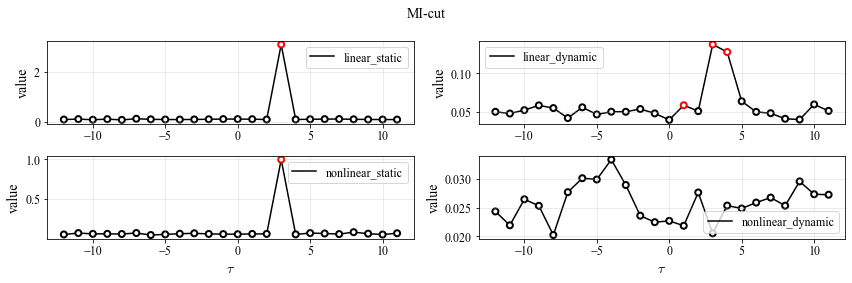

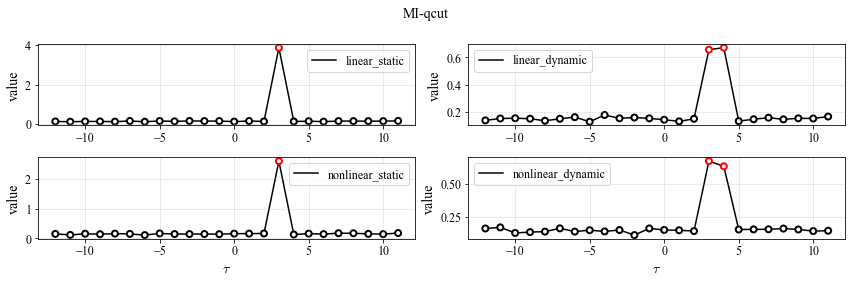

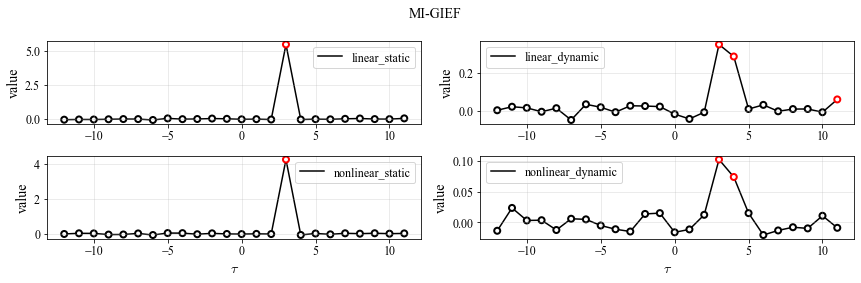

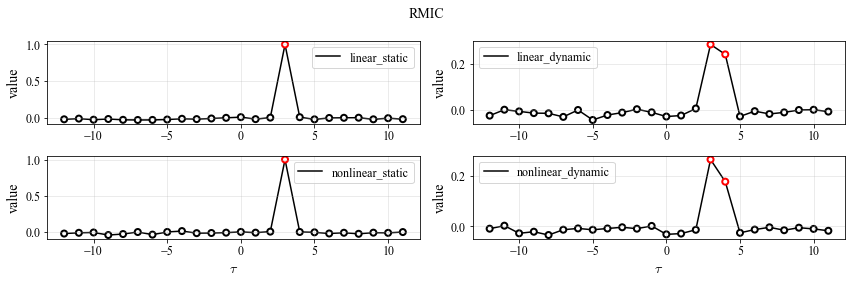

In [5]:
rounds = 100
taus = np.arange(-12, 12)
methods = ["PearsonCorr", "SpearmanCorr", "DistCorr", "MI-cut", "MI-qcut", "MI-GIEF", "RMIC"]

for method in methods:
    td_assocs_lst, td_indeps_lst = [], []
    for label in labels:
        x, y = data[[f"x_{label}"]].values, data[[f"y_{label}"]].values
        
        # 归一化
        x, y = normalize(x).flatten(), normalize(y).flatten()

        if method == "RMIC":
            td_assocs, td_indeps = detect_time_delayed_assoc(
                x, y, taus, show=False, alpha=0.01, rounds=rounds, method=method, encode=False)
        else:
            td_assocs, td_indeps = detect_time_delayed_assoc(
                x, y, taus, show=False, alpha=0.01, rounds=rounds, method=method)
        
        td_assocs_lst.append(td_assocs)
        td_indeps_lst.append(td_indeps)

    plt.figure(figsize=(12, 4))
    for i, label in enumerate(labels):
        td_assocs, td_indeps = td_assocs_lst[i], td_indeps_lst[i]
        plt.subplot(2, 2, i + 1)
        plt.scatter(
            taus, td_assocs, edgecolors=["k" if p==1 else "r" for p in td_indeps], c="w", lw=2, zorder=1)
        plt.plot(taus, td_assocs, c="k", lw=1.5, zorder=0)
        plt.grid(alpha=0.3, zorder=-1)
        if i in [2, 3]:
            plt.xlabel("$\\tau$")
        plt.ylabel("value")
        plt.legend([label])
    plt.suptitle(method, fontsize=14)
    plt.tight_layout()
    plt.show()

从以上测试结果可见：
1. 所有方法均能准确识别linear_static中x对y的作用时延为3;
2. 耗时最低的三种相关系数中, PearsonCorr和SpearmanCorr对于其他三个系统时延识别效果很差, 只有DistCorr在四个系统中表现最佳;
3. 信息熵方法中, MI-qcut和RMIC识别效果最佳, MI-GIEF次之, MI-cut最差.